<a href="https://colab.research.google.com/github/solsordelli/ProyectoDS_ParteI_Sordelli/blob/main/Proyecto_ParteIII_Sordelli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***¿Qué tan bien funcionan los sistemas de Seguridad?***

En este proyecto se evaluara, a traves de un modelo, cuál será la acción tomada por los sistemas de seguridad (Blocked, Logged, Ignored) con base en los datos del ataque. El objetivo principal es anticipar la respuesta del sistema e identificar puntos de mejora en los sistemas de deteccion.
En el analisis anterior se plantearon las siguientes hipotesis,
Pregunta 1: Cuáles son los protocolos más utilizados en los ciberataques?

Hipótesis: Se espera que ciertos protocolos, como HTTP y TCP, sean más frecuentemente utilizados en los ciberataques debido a su prevalencia en la comunicación de redes.

Pregunta 2: El número de eventos bloqueados/ingresados/ignorados aumenta o disminuye con valores más altos de Anomaly Scores?

Hipótesis: Es probable que los eventos con valores más altos de Anomaly Scores estén asociados con una mayor cantidad de eventos bloqueados, ya que puntajes más altos podrían indicar actividades más sospechosas.

Pregunta 3: La mayor cantidad de ataque se producen por la madrugada? Esto podria deberse a que en esos horarios la seguridad baja ya que no suelen haber persoans controlando los sistemas y trabajando sobre los mismos

Hipótesis: Se espera encontrar una mayor concentración de ataques durante la madrugada, lo cual podría estar relacionado con la reducción de la supervisión durante esas horas.

Pregunta 4: Cómo varía la frecuencia de ataques a lo largo del año para cada tipo de ataque?

Hipótesis: Es posible que algunos tipos de ataques sigan patrones estacionales, con picos en ciertas épocas del año.

Las cuales perimitieron tener mayor conocimiento y dominio de los datos dentro del DataSet


Importamos las librerias a utilizar para el analisis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Se carga el DataSet utilizado

In [3]:
uploaded = files.upload()
df = pd.read_csv('cybersecurity_attacks.csv', sep=',', encoding='latin1')
df.info()
df.head()

Saving cybersecurity_attacks.csv to cybersecurity_attacks (1).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               40000 non-null  object 
 1   Source IP Address       40000 non-null  object 
 2   Destination IP Address  40000 non-null  object 
 3   Source Port             40000 non-null  int64  
 4   Destination Port        40000 non-null  int64  
 5   Protocol                40000 non-null  object 
 6   Packet Length           40000 non-null  int64  
 7   Packet Type             40000 non-null  object 
 8   Traffic Type            40000 non-null  object 
 9   Payload Data            40000 non-null  object 
 10  Malware Indicators      20000 non-null  object 
 11  Anomaly Scores          40000 non-null  float64
 12  Alerts/Warnings         19933 non-null  object 
 13  Attack Type             4

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


# **Analisis de las Variables**

En primer lugar nos interesa saber cuál es el balance de las acciones tomadas (Action Taken) ya que va a ser nuestra variable principal

In [4]:
print(df['Action Taken'].value_counts())

Action Taken
Blocked    13529
Ignored    13276
Logged     13195
Name: count, dtype: int64


A simple vista se puede observar que la categoria esta muy balanceada entre las 3 acciones, pero se ve mas claro a traves del grafico de barras.
Por otro lado, se verifica la distribucion de Packet Length y Anomaly Scores, esto se debe a que se busca identificar si hay valores atipicos y entender cuál es el comportamiento habitual de estas variables

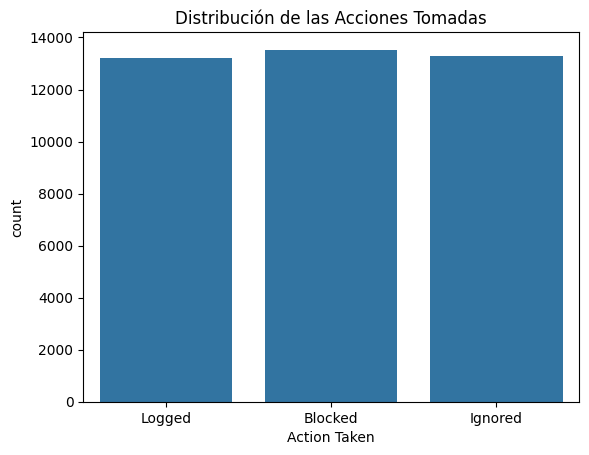

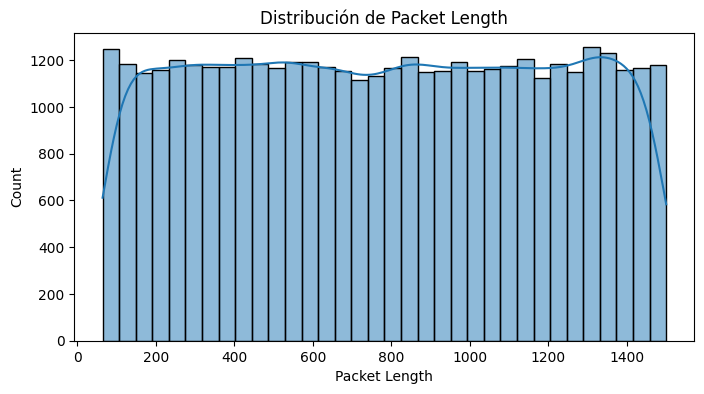

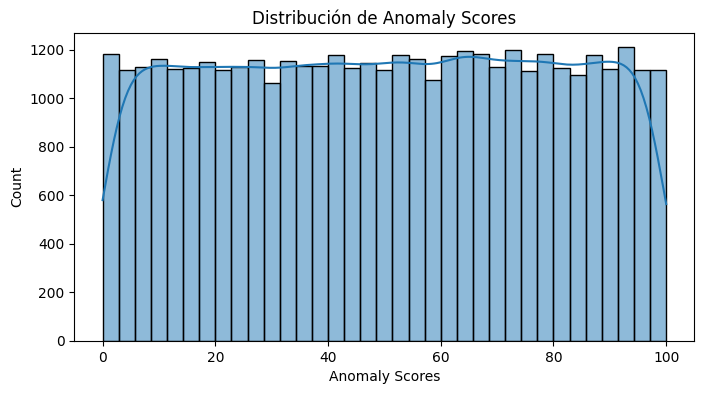

In [5]:
# Gráfico de barras para ver la distribución
sns.countplot(x='Action Taken', data=df)
plt.title('Distribución de las Acciones Tomadas')
plt.show()

# Gráficos de distribución de algunas características numéricas
for col in ['Packet Length', 'Anomaly Scores']:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()

Luego del analisis se identifica que hay algunos picos pequeños en ambas variables pero que en general se encuentran balanceados.

# **Limpieza de datos**

Vamos a comenzar con la limpieza de datos, como se identifico al pincipio, hay una gran cantidad de columnas que posee datos "Null" por lo tanto, se procedeera a elimiminar aquellas que poseen mas de un 50% de valores nulos ya que no seran de ayuda cuando se realice el modelo.
Por otro lado, se identifican las columnas categoricas para luego saber a cuales deberemos aplicarles el One-Hot Encoding y seran relevantes para el analisis.
Tambien tenemos columnas numéricas las cules podemos identificar y correlacionar para obtener la matriz de correlación y eliminar las features altamente correlacionadas


Columnas categóricas: Index(['Timestamp', 'Source IP Address', 'Destination IP Address', 'Protocol',
       'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators',
       'Attack Type', 'Attack Signature', 'Action Taken', 'Severity Level',
       'User Information', 'Device Information', 'Network Segment',
       'Geo-location Data', 'Proxy Information', 'Firewall Logs',
       'Log Source'],
      dtype='object')


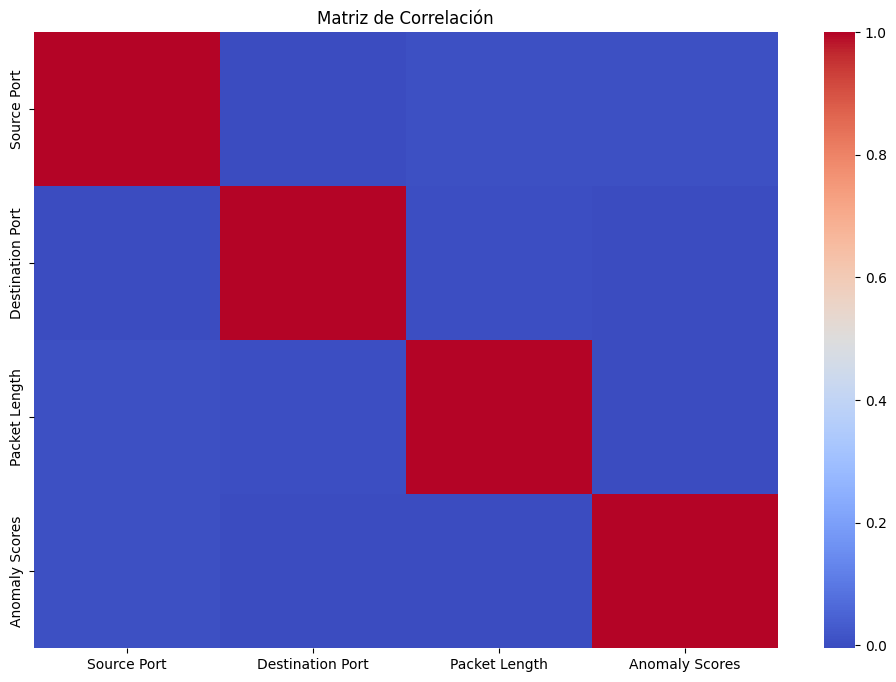

Dimensiones del dataset tras la selección de características: (40000, 27)


In [7]:
df_cleaned = df.dropna(thresh=len(df)*0.5, axis=1)

categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
print("Columnas categóricas:", categorical_cols)

# Elige algunas columnas categóricas relevantes
selected_categorical_cols = ['Protocol', 'Packet Type', 'Traffic Type', 'Attack Type', 'Severity Level']

# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df_cleaned, columns=selected_categorical_cols, drop_first=True)

df_numeric = df_encoded.select_dtypes(include=['number'])
correlation_matrix = df_numeric.corr()

# Matriz de correlación
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

correlated_features = set()
correlation_threshold = 0.85
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

df_selected = df_encoded.drop(columns=correlated_features)

print("Dimensiones del dataset tras la selección de características:", df_selected.shape)


Luego de todo el analisis y el tratamiento de los datos, se pudieron reducir las features a 27

# **Creacion del modelo**

Como se observa, este conjunto de datos posee Datos Categóricos y Numéricos, por lo tanto el modelo a utilizar sera un Random Forest ya que puede manejar tanto características categóricas como numéricas sin necesidad de una transformación extensa. Esto es ventajoso en un conjunto de datos de ciberataques donde las características pueden ser diversas.

Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2733
           1       1.00      1.00      1.00      2622
           2       1.00      1.00      1.00      2645

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



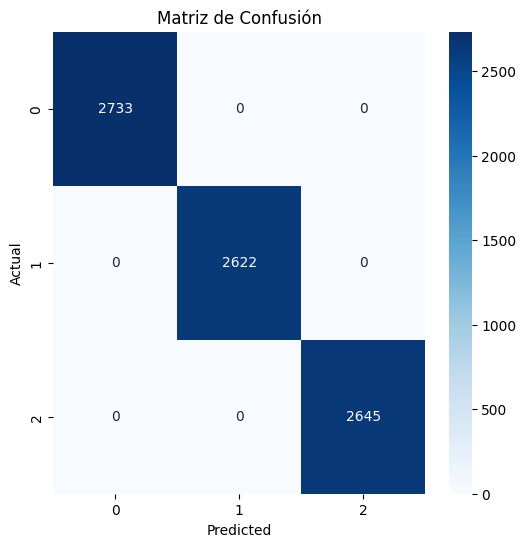

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df_selected['Action Taken'] = df['Action Taken']

# Eliminar columnas no numéricas irrelevantes
columns_to_drop = ['Timestamp', 'Source IP Address', 'Destination IP Address', 'Payload Data',
                   'User Information', 'Device Information', 'Geo-location Data', 'Proxy Information']

df_selected_clean = df_selected.drop(columns=columns_to_drop)

# Verificar si quedan columnas categóricas y convertirlas si es necesario (One-Hot Encoding)
df_selected_clean = pd.get_dummies(df_selected_clean, drop_first=True)

# Asegúrate de que 'Action Taken' siga en el dataset
if 'Action Taken' not in df_selected_clean.columns:
    df_selected_clean['Action Taken'] = df['Action Taken']

# Definir las características (X) y la variable objetivo (y)
X = df_selected_clean.drop(columns=['Action Taken'])
y = df_selected_clean['Action Taken']

# Convertir la variable objetivo a numérica si es necesario
y = y.astype('category').cat.codes

# Dividir el dataset en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Métricas de evaluación
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualización
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Matriz de Confusión')
plt.show()

# **Conclusión**

Dados los resultados obtenidos, el modelo de Random Forest alcanzó una precisión del 100% en el conjunto de prueba, lo que da a entender que el modelo es altamente efectivo en la clasificación de las acciones tomadas (Blocked, Logged, Ignored) basándose en las features del dataset.

Este análisis no solo proporciona una comprensión clara del comportamiento de los sistemas de seguridad, sino que también abre la puerta a futuras investigaciones y mejoras. El objetivo es seguir perfeccionando la capacidad del modelo para anticipar acciones de seguridad, optimizando así la respuesta ante ciberataques y aumentando la seguridad organizacional.